In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import matplotlib as mpl
import warnings

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128

df_fleats = pd.read_csv('data/marketing-breakdown-detailed.csv')
df_fleats = df_fleats.append(pd.read_csv('data/marketing-breakdown-detailed (2).csv'))
df_fleats = df_fleats.append(pd.read_csv('data/marketing-breakdown-detailed (3).csv'))
df_fleats = df_fleats.append(pd.read_csv('data/marketing-breakdown-detailed (4).csv'))

selected_features = ['Marketing Code','App Source', 'Web Source', 'Classification','Enquired',
                     'Loan Amount']
target = 'Enquiry Status';
whole_set = selected_features + [target]

data_set = df_fleats[whole_set]
data_set = data_set.replace('On Hold','Rejected')
# convert loan amount to number type, and change string to NaN
data_set['Loan Amount'] = pd.to_numeric(data_set['Loan Amount'],errors='coerce')
data_set = data_set.dropna(axis=0, how='any')

data_set['Loan Amount'] = data_set['Loan Amount'].astype(int)

In [2]:
from datetime import datetime
from dateutil.parser import parse

temp = pd.DatetimeIndex(data_set['Enquired'])
data_set['Enquired'] = temp
data_set['Enquired Date'] = pd.to_datetime(temp.date)
data_set['Enquired Time'] = temp.time
# data_set = data_set.drop(['Enquired'],1)

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (data_set['Enquired Date'] > start_date) & (data_set['Enquired Date'] <= end_date)
data_set = data_set.loc[mask].reset_index(drop=True)
data_set['day_of_week'] = data_set['Enquired Date'].dt.weekday_name

# X = data_set[['Marketing Code','App Source', 'Web Source', 'Classification','Enquired Date',]]
X = data_set[data_set.keys()]
X = X.drop(['Enquiry Status'],1)
y = data_set[target]

In [3]:
print(X['day_of_week'].unique())

['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']


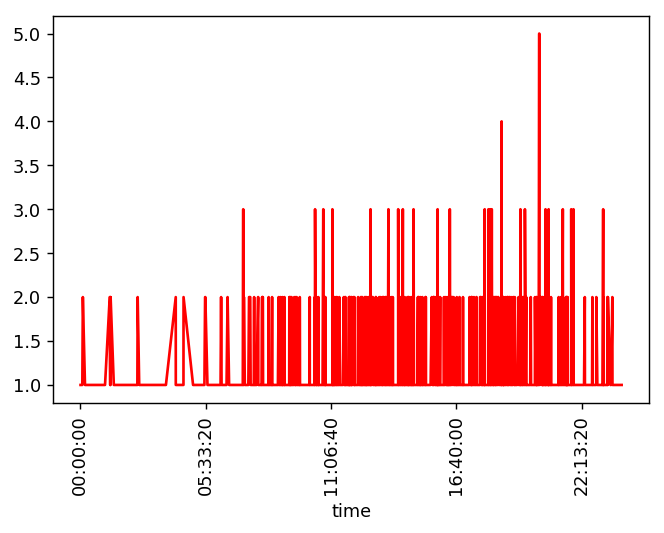

In [4]:
import random
import matplotlib.dates as mdates
import matplotlib.mlab as mlab

# generate some random data (approximately over 5 years)
data_1 = data_set[['Enquiry Status','Enquired Date']]
data_2 = data_set[['Enquiry Status','Enquired Time']]

plot_date = data_1.groupby(['Enquired Date', 'Enquiry Status']).size().reset_index(name="counts")
plot_date = plot_date.loc[plot_date['Enquiry Status'] == 'Accepted']

plot_time = data_2.groupby(['Enquired Time', 'Enquiry Status']).size().reset_index(name="counts")
plot_time = plot_time.loc[plot_time['Enquiry Status'] == 'Accepted']


plt.plot_date(x=plot_time['Enquired Time'], y=plot_time['counts'],fmt="r-")
plt.xticks(rotation=90)
plt.show()

In [5]:
print("Keys of enquiries_dataset: \n{}".format(X.keys()))

Keys of enquiries_dataset: 
Index(['Marketing Code', 'App Source', 'Web Source', 'Classification',
       'Enquired', 'Loan Amount', 'Enquired Date', 'Enquired Time',
       'day_of_week'],
      dtype='object')


In [6]:
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (19662, 9)
Shape of y: (19662,)


In [7]:
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output
       

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

le = LabelEncoder()
# Categorial feature ecoding
encode_df = X.loc[:, X.columns != 'Loan Amount']
X = MultiColumnLabelEncoder(columns = encode_df.keys()).fit_transform(X, y)

In [9]:
# feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
selected_X = model.transform(X)

# Get idxs of columns to keep
idxs_selected = model.get_support(indices=True)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
# rescale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(X_train_scaled, y_train)
pred_kn = kn.predict(X_test)
print("Test score: {:.2f}".format(kn.score(X_test_scaled, y_test)))

Test score: 0.89


In [12]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss="hinge", penalty="l2")
sgd.fit(X_train_scaled, y_train)
pred_sgd = sgd.predict(X_test)
print("Test score: {:.2f}".format(sgd.score(X_test_scaled, y_test)))

Test score: 0.87


In [13]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train_scaled)
clf = SGDClassifier()  
clf.fit(X_train_scaled, y_train)
print("Test score: {:.2f}".format(clf.score(X_test_scaled, y_test)))

Test score: 0.88


In [14]:
from sklearn import svm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

svc = svm.SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print("Test score: {:.2f}".format(svc.score(X_test, y_test)))

# scores = cross_val_score(clf, X, y, cv=5)
# scores
# N = range(1, 16)
# for n in N:
#     pca = KernelPCA(n_components=n)
#     X_n_kept = pca.fit_transform(X_test_scaled)
#     # Estimate accuracy on the data set with top n components
#     classifier = svm.SVC(gamma=0.001)
#     score_n_components = cross_val_score(classifier, X_n_kept, y_test).mean()
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))

Test score: 0.92


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train_scaled, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_scaled, y_test)))

scores = cross_val_score(rfc, X_test_scaled, y_test)
# print("Cross-validation scores: {}".format(scores.mean()))
# N = range(1, 100)
# best_score = 0
# n_estimators = 1
# for n in N:
#     rfc = RandomForestClassifier(n_estimators=n, n_jobs=-1)
#     rfc.fit(X_train_scaled, y_train)
#     score_n_components = cross_val_score(clf, X_test_scaled, y_test).mean()
#     if(best_score < score_n_components):
#         best_score = score_n_components
#         n_estimators = n
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))
# print('best socre is: {1:.2f} with {0} estimators'.format(best_score,n_estimators))

Test score: 0.92


 1) Loan Amount                    0.221812
 2) Enquired Time                  0.177498
 3) Enquired                       0.175651
 4) Marketing Code                 0.133792
 5) Enquired Date                  0.101900
 6) App Source                     0.071394
 7) Classification                 0.062366
 8) day_of_week                    0.055450
 9) Web Source                     0.000137


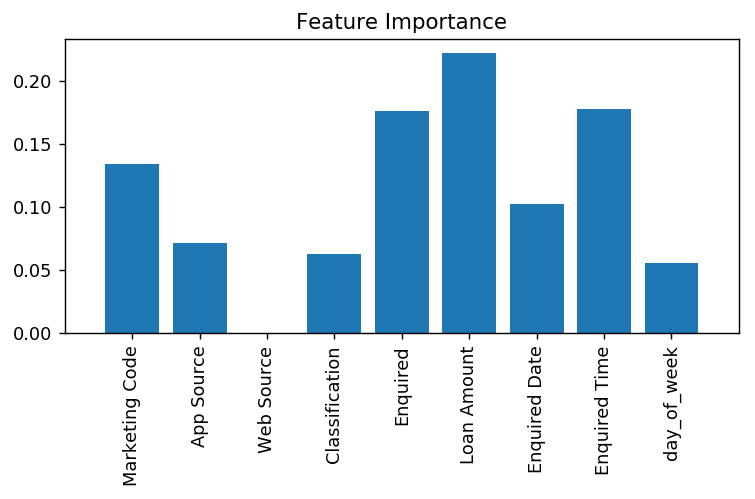

In [16]:
feat_labels = X.columns[:]
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances,align='center')
plt.xticks(range(X_train.shape[1]),feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

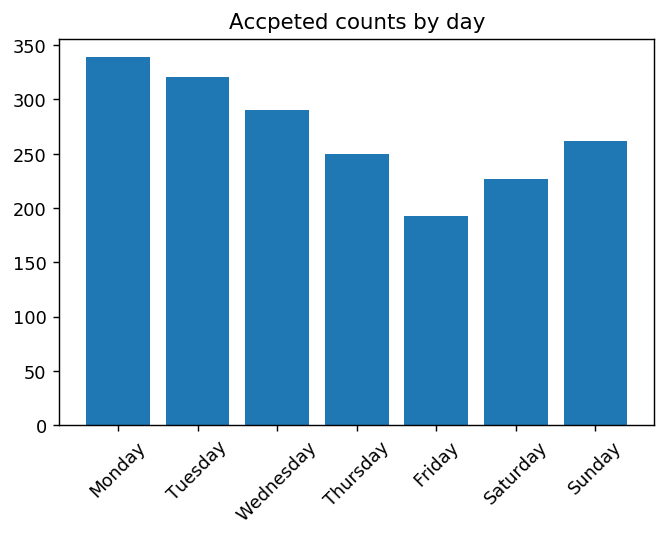

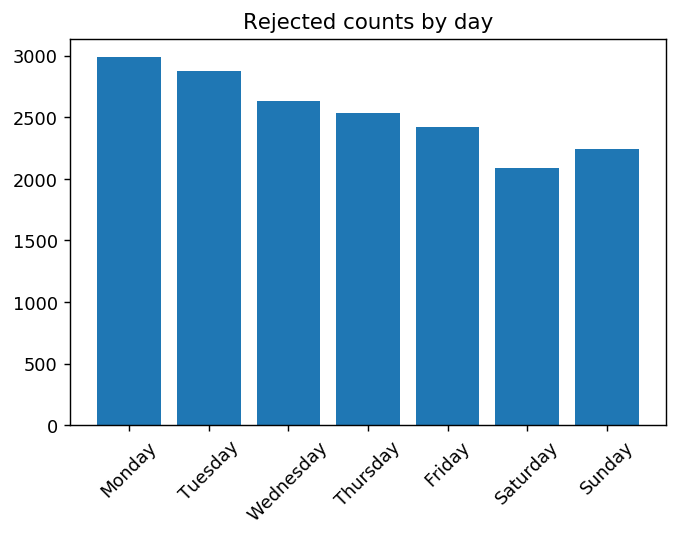

In [17]:
import calendar



plt_accepted = data_set.loc[data_set['Enquiry Status'] == 'Accepted']

# get and sort acceptances by day
count_day_accepted = plt_accepted.groupby(['day_of_week']).size().reset_index(name="counts")
weekdays = list(calendar.day_name)
mapping = {day: i for i, day in enumerate(weekdays)}
key = count_day_accepted['day_of_week'].map(mapping)
count_day_accepted = count_day_accepted.iloc[key.argsort()].reset_index(drop=True)




plt_rejected = data_set.loc[data_set['Enquiry Status'] == 'Rejected']

count_day_rejected = plt_rejected.groupby(['day_of_week']).size().reset_index(name="counts")
weekdays = list(calendar.day_name)
mapping = {day: i for i, day in enumerate(weekdays)}
key = count_day_rejected['day_of_week'].map(mapping)
count_day_rejected = count_day_rejected.iloc[key.argsort()].reset_index(drop=True)



plt_X1 = plt_accepted[['Loan Amount','day_of_week']]
plt_y1 = plt_accepted[['Enquiry Status']]

# ax = count_day.plot()
# ax.set_xlabel("Day")
# plt.plot_date(x=count_day['day_of_week'], y=count_day['counts'],fmt="r-")
# plt.plot_date(x=count_date['Enquired Date'], y=count_date['counts'],fmt="r-")

# plt.plot(count_day_accepted['day_of_week'], count_day_accepted['counts'])
# plt.xticks(rotation=45)
# plt.show()

# print(count_day_accepted['day_of_week'].shape[0])
plt.title('Accpeted counts by day')
plt.bar(range(count_day_accepted['day_of_week'].shape[0]), count_day_accepted['counts'])
plt.xticks(range(count_day_accepted['day_of_week'].shape[0]),count_day_accepted['day_of_week'].values, rotation=45)
plt.show()

plt.title('Rejected counts by day')
plt.bar(range(count_day_rejected['day_of_week'].shape[0]), count_day_rejected['counts'])
plt.xticks(range(count_day_rejected['day_of_week'].shape[0]),count_day_rejected['day_of_week'].values, rotation=45)
plt.show()
# count2.plot(logy=True)
# plt_X2 = plt_rejected[['Loan Amount','day_of_week']]
# plt_y2 = plt_rejected[['Enquiry Status']]
# # plt_X = X.sort_values(by=['Loan Amount'])
# # plt_X = plt_X['Loan Amount']
# # display(plt_X)

# fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
# # ax.plot(plt_X, orig_y)
# # plt.scatter(plt_X1['day_of_week'], plt_X1['Loan Amount'],color='red', marker='o', label='Accepted')
# # plt.scatter(plt_X2['day_of_week'], plt_X2['Loan Amount'], color='blue', marker='x', label='Rejected')
# # plt.plot(plt_X1['day_of_week'], plt_y1, label='Accepted')
# # plt.plot(plt_X2['day_of_week'],plt_y2, label='Rejected')

# plt.xlabel('Day')
# plt.xticks(rotation=45)
# plt.ylabel('Loan Amount')
# plt.legend(loc='upper left')
# plt.show()

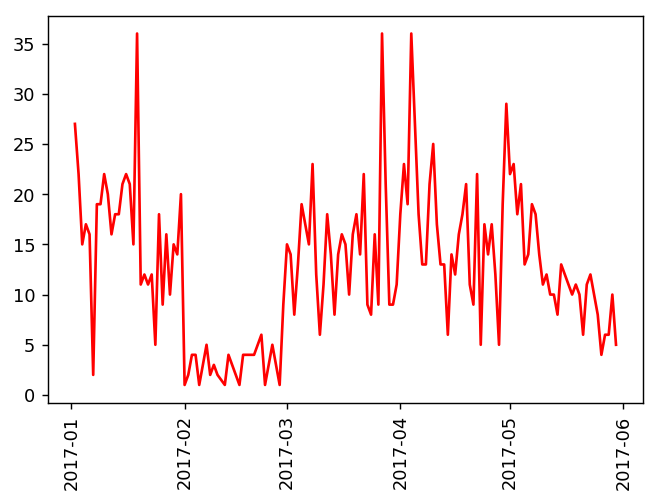

In [18]:
count_date_accepted = plt_accepted.groupby(['Enquired Date']).size().reset_index(name="counts")
count_date_rejected = plt_rejected.groupby(['Enquired Date']).size().reset_index(name="counts")

plt.plot_date(x=count_date_accepted['Enquired Date'], y=count_date_accepted['counts'],fmt="r-")
plt.xticks(rotation=90)
plt.show()

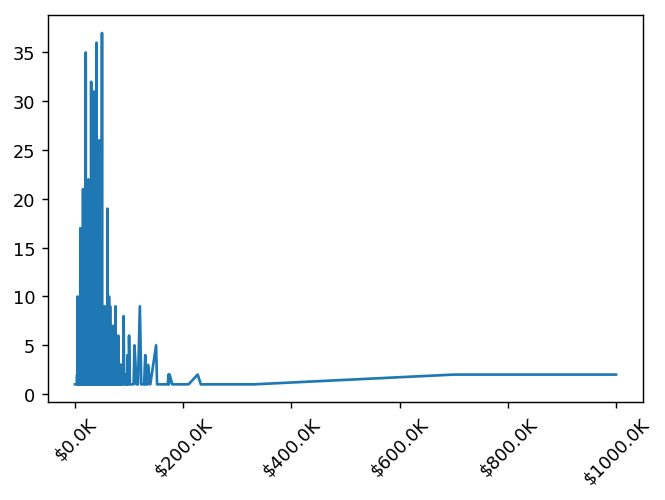

In [19]:
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fK' % (x*1e-4)

formatter = FuncFormatter(millions)

count_amount_accepted = plt_accepted.groupby(['Loan Amount']).size().reset_index(name="counts")
count_amount_rejected = plt_rejected.groupby(['Loan Amount']).size().reset_index(name="counts")

# count_amount_accepted.to_csv('test.csv')
# display(count_amount_accepted)
fig, ax = plt.subplots()
plt.plot(count_amount_accepted['Loan Amount'], count_amount_accepted['counts'])
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(formatter)
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix

print("KNeighborsClassifier:")
tn, fp, fn, tp = confusion_matrix(y_test, pred_kn).ravel()
print(confusion_matrix(y_test, pred_kn))
print (tn, fp, fn, tp)
print("\nSGDClassifier:")
print(confusion_matrix(y_test, pred_sgd))
print("\nSVC:")
print(confusion_matrix(y_test, pred_svc))
print("\nRandomForestClassifier")
print(confusion_matrix(y_test, pred_forest))

KNeighborsClassifier:
[[   3  776]
 [   5 7081]]
3 776 5 7081

SGDClassifier:
[[ 773    6]
 [4351 2735]]

SVC:
[[ 111  668]
 [   0 7086]]

RandomForestClassifier
[[ 247  532]
 [2059 5027]]


In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

print("f1 score KNeighborsClassifier: {:.2f}".format(f1_score(y_test, pred_kn, average='weighted')))
print("f1 score SGDClassifier: {:.2f}".format(f1_score(y_test, pred_sgd,average='weighted')))
print("f1 score SVC: {:.2f}".format(f1_score(y_test, pred_svc,average='weighted')))
print("f1 score RandomForestClassifier: {:.2f}".format(f1_score(y_test, pred_forest,average='weighted')))
print()
print("precision score KNeighborsClassifier: {:.2f}".format(precision_score(y_test, pred_kn, average='weighted')))
print("precision score SGDClassifier: {:.2f}".format(precision_score(y_test, pred_sgd,average='weighted')))
print("precision score SVC: {:.2f}".format(precision_score(y_test, pred_svc,average='weighted')))
print("precision score RandomForestClassifier: {:.2f}".format(precision_score(y_test, pred_forest,average='weighted')))

f1 score KNeighborsClassifier: 0.85
f1 score SGDClassifier: 0.53
f1 score SVC: 0.89
f1 score RandomForestClassifier: 0.73

precision score KNeighborsClassifier: 0.85
precision score SGDClassifier: 0.91
precision score SVC: 0.92
precision score RandomForestClassifier: 0.83


In [22]:
# input_x = X.iloc[:]
# input_x_test = X.iloc[:,idxs_selected]
# # input_x = input_x.iloc[0,idxs_selected]

# # input_x = input_x.drop('Enquiry Status', 1)

# input_x_test = MultiColumnLabelEncoder(columns = input_x_test.keys()).fit_transform(input_x_test)
# input_x_test = scaler.fit_transform(input_x_test)

# # for row in input_x:
# #     result = rfc.predict(row)[0]
# #     proba = np.max(rfc.predict_proba(row))    

# #     print('reuslt: {}'.format(le.inverse_transform(result)))
# #     print('probability: {0}%'.format(proba))
# #     print()

# # result = rfc.predict(input_x)[0]
# # proba = np.max(rfc.predict_proba(input_x))    

# # print('reuslt: {}'.format(le.inverse_transform(result)))
# # print('probability: {0}%'.format(proba))
# result = rfc.predict(input_x_test)
# result = le.inverse_transform(result)
# proba = rfc.predict_proba(input_x_test)   
# proba = [np.max(p) for p in proba]
# input_x.to_csv('example.csv')

In [23]:
# input_x = input_x.assign(predict=result.tolist())
# input_x = input_x.assign(possibility=proba)
# input_x.head()
# input_x.to_csv('result/v1.csv')